In [1]:
#importing libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#importing files in pandas dataframe
train = pd.read_csv('train.csv',header=0)
test = pd.read_csv('test.csv',header = 0)
labels = train['label']
train.drop('label',axis=1, inplace =True)
#test shape =(28000,784), train shape =(42000,784), labels shape = (42000,1)

In [3]:
#Converting dataframes into numpy arrays
train = train.as_matrix()
test = test.as_matrix()
labels = labels.as_matrix()

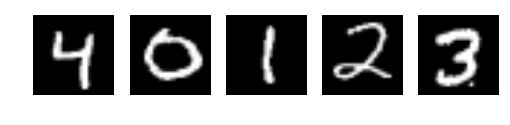

Labels: [4, 0, 1, 2, 3]


In [4]:
#Visualization of few random hand written digits
fig = plt.figure()
randLabels = []
for i in range(1,6):
    k = random.randrange(0,42000,10)
    ax = fig.add_subplot(1,5,i)
    ax.imshow(train[k,:].reshape(28,28),'gray')
    ax.axis('off')
    randLabels.append(labels[k])
plt.show()
print('Labels: {}'.format(randLabels))

In [5]:
#Splitting training dataset into cross-validation dataset(Using normal splitting instead of 5 fold cross validation)
train, valid, labels, validLabels = train_test_split(train, labels, test_size = 0.25)
#Checking sizes of training and validation datasets
print(np.shape(train))
print(np.shape(valid))
print(np.shape(labels))
print(np.shape(validLabels))

(31500, 784)
(10500, 784)
(31500,)
(10500,)


In [6]:
#PreProcessing(Data Compression)
pca = PCA()
pca.fit(train)
VarianceRatio = pca.explained_variance_ratio_

In [7]:
#Finding number of principal components
#Retaining 85% of total variance 
TotVar = 0 
for idx, Var in enumerate(VarianceRatio):
    TotVar += Var 
    if(TotVar>=0.85): 
        break 
print('Total Retained Variance: {}'.format(TotVar)) 
print('Number of principal components {}'.format(idx))

Total Retained Variance: 0.8507515535203991
Number of principal components 58


In [8]:
#Again fitting pca for 153 principal components
pcaRed = PCA(n_components = 58)
pcaRed.fit(train)
#Compressing training and testing data using fitted data
train = pcaRed.fit_transform(train)
test = pcaRed.fit_transform(test)
valid = pcaRed.fit_transform(valid)

In [9]:
#PreProcessing data
scaler = preprocessing.StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
valid = scaler.transform(valid)

In [30]:
#Trying SVM classifier
#Increasing C and Gamma as on decreasing accuracy is not increasing, hence high bias
clf =SVC(C=60, gamma=0.01)
t0 = time.time()
clf.fit(train, labels)
TrainPred = clf.predict(train)
TrainScore = accuracy_score(labels,TrainPred)
ValidPred = clf.predict(valid)
ValidScore = accuracy_score(validLabels,ValidPred)
t1 = time.time()
print('Training and cross-validation accuracy are : {} and {}'.format(TrainScore, ValidScore ))
print('Total training and cross-validation accuracy calculation time: {}'.format(np.abs(t1-t0)))

Training and cross-validation accuracy are : 1.0 and 0.7331428571428571
Total training and cross-validation accuracy calculation time: 134.4522466659546


(31500, 58)


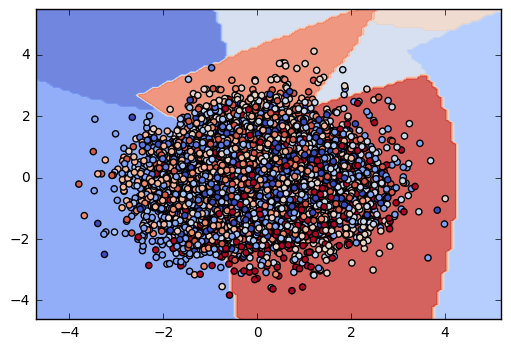

In [28]:
#Plotting classifier decision surface to visualise(using PCA to compress data to two components)
print(train.shape)
pcaPlot = PCA(n_components =2)
pcaPlot.fit(train)
trainPlot = pcaPlot.fit_transform(train)
validPlot = pcaPlot.fit_transform(valid)
# create a mesh to plot in
x_min, x_max = trainPlot[:, 0].min() - 1, trainPlot[:, 0].max() + 1
y_min, y_max = trainPlot[:, 1].min() - 1, trainPlot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(pcaPlot.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(validPlot[:, 0], validPlot[:, 1], c=validLabels, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [41]:
#using classifier to predict test images on public leader board
pred = clf.predict(test)
dfPred = pd.read_csv('sample_submission.csv',header=0)
dfPred['Label']= pd.DataFrame(pred)
dfPred.to_csv('mySubmission.csv', index=False)